# Problem Statement:

###### The sinking of the RMS Titanic is one of the most infamous shipwrecks in
history. On April 15, 1912, during her maiden voyage, the Titanic sank after
colliding with an iceberg, killing numerous passengers and crew. This
sensational tragedy shocked the international community and led to better
safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there
were not enough lifeboats for the passengers and crew. Although there was
some element of luck involved in surviving the sinking, some groups of people
were more likely to survive than others, such as women, children, and the
upper-class.
In this, we ask you to complete the analysis of what sorts of people were likely
to survive. In particular, we ask you to apply the tools of machine learning to
predict which passengers survived the tragedy.

# Import Packages

In [177]:
import math, time, random, datetime
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
import warnings
warnings.filterwarnings('ignore')

# Data Importing

In [131]:
train = pd.read_csv('train.csv')

In [132]:
train.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Gender       891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [30]:
train.nunique()

Unnamed: 0     891
PassengerId    891
Survived         2
Pclass           3
Name           891
Gender           2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [31]:
train.describe()

,Unnamed: 0,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.386083,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.487123,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Handling Missing Values

In [32]:
missing_per = round(train.isnull().sum()/len(train)*100,2)
missing_per[missing_per != 0]

Age         19.87
Cabin       77.10
Embarked     0.22
dtype: float64

###### Out of the 891 train records, 20% of the data has no Age for the passangers and 77% of data with missing cabin information. Also 2 records dont have the Embarked port name.
Let's handle these missing data.

In [33]:
missing_count=train.isnull().sum()
missing_count[missing_count >0.0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [34]:
missing_count=train.isnull().sum()
missing_count[missing_count >0.0]

Age         177
Cabin       687
Embarked      2
dtype: int64

###### Since, both these persons dont have any siblings / spouses/ parents or children. We cannot infer there Port of Embarkment.Now we can,

1. impute the missing value with the mode of Embarked port.
2. remove these two records from analysis and modeling

Going with the first option, imput the missing port of embarkment with the mode i.e S: 644

In [133]:
train['Embarked'].fillna('S',inplace=True)
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### Handling the missing Age

In [134]:
train[train.Age.isnull()].Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [135]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [136]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

In [137]:
train.drop('Cabin', axis=1 , inplace = True)

In [138]:
train.drop('Unnamed: 0', axis=1 , inplace = True)

In [139]:
train.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Treating Outliers

In [43]:
train.Age.describe()

count    891.000000
mean      29.066409
std       13.244532
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

##### Age of the passangers are gradually increasing suggesting no outliers in Age.


# Exploratory Data Analysis

### Univariate Analysis

#### Feature: PassengerId

In [20]:
train.PassengerId.head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

###### This column clearly is a Id assigned to the passenger. This wont be of any significance in predicting the survival. We will later remove this column from analysis.

#### Feature: Survived

In [21]:
print(train.Survived.value_counts())
### Checking the Survival Rate
survival_rate = round((sum(train[train['Survived']==1]['Survived'])/len(train['Survived'].index))*100,2)
print('Survival Rate : {}'.format(survival_rate))

0    547
1    335
Name: Survived, dtype: int64
Survival Rate : 37.98


<Axes: xlabel='Survived', ylabel='count'>

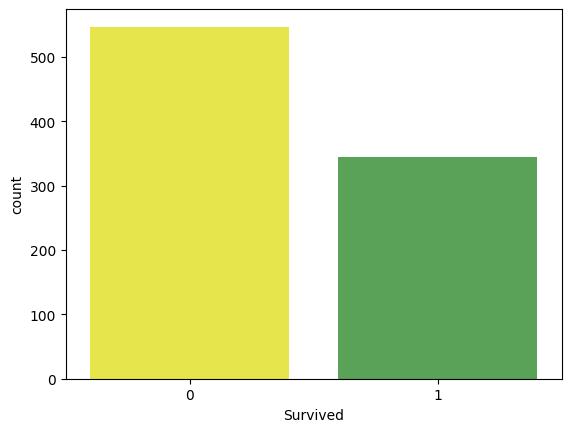

In [7]:
sns.countplot(x='Survived',data=train,palette='Set1_r')

###### In this training data we have 549 passangers who survived and 342 passangers who din't survive.

The training data has a Survival Rate of 38.38%

#### Feature: Pclass

###### This feature tells us about the Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd of onboard passengers.

<Axes: ylabel='Pclass'>

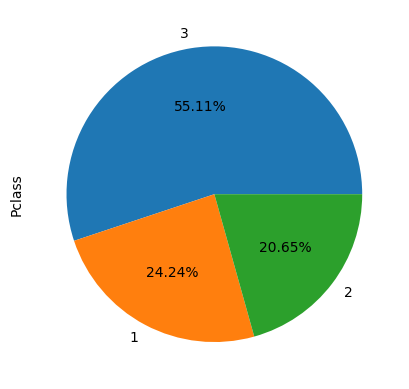

In [45]:
train['Pclass'].value_counts(normalize=True).plot(kind='pie',autopct='%1.2f%%')

<Axes: xlabel='Survived', ylabel='count'>

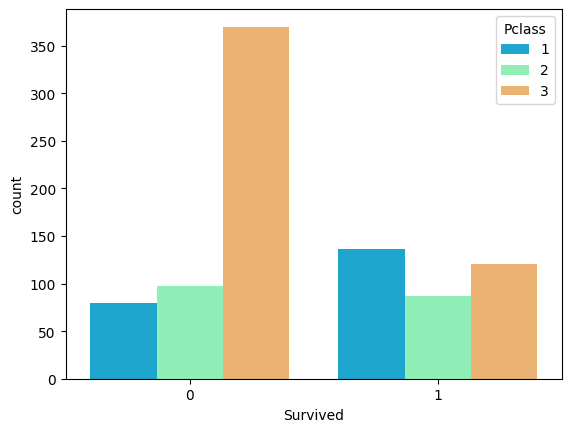

In [10]:
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

###### This feature tells us about the Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd of onboard passengers and how the survival rate according to Pclass.

#### Feature: Gender

###### This column information about the Gender of the passanger, Male or Female

<Axes: xlabel='Survived', ylabel='count'>

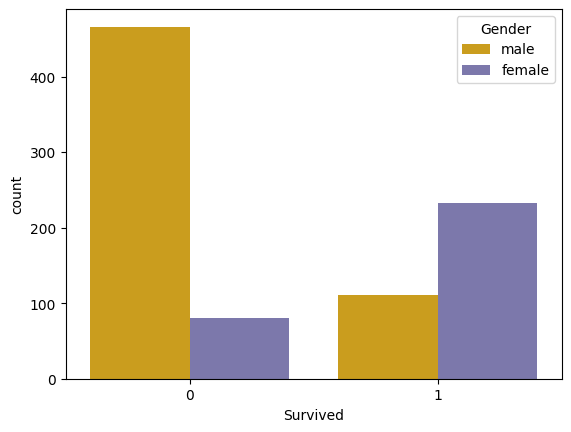

In [46]:
sns.countplot(x='Survived',hue='Gender',data=train,palette='Dark2_r')

In [ ]:
Men had a low probability of surviving.

#### Feature: Age

###### Information about the Age of the passanger.

<Axes: xlabel='Age', ylabel='Density'>

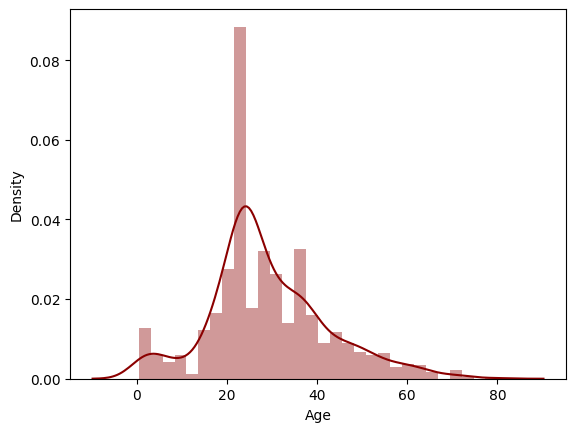

In [48]:
sns.distplot(train['Age'],kde=True,color='darkred',bins=30)

In [49]:
train.groupby('Survived').Age.mean()

Survived
0    29.627971
1    28.173459
Name: Age, dtype: float64

<Axes: >

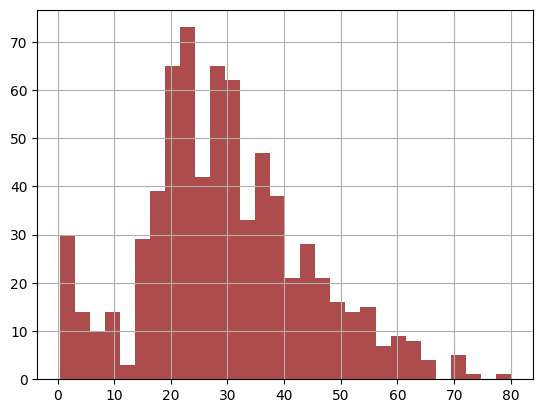

In [12]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<Axes: xlabel='SibSp', ylabel='count'>

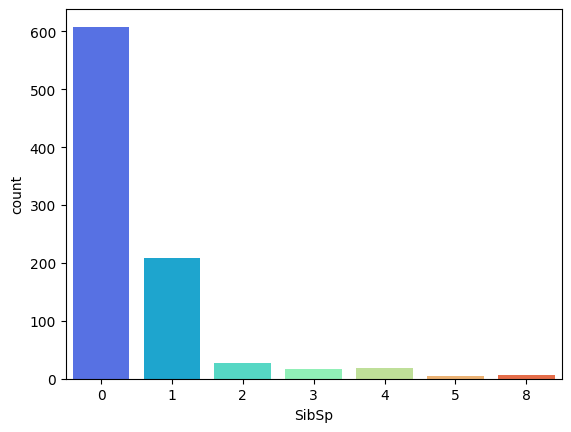

In [13]:
sns.countplot(x='SibSp',data=train,palette='rainbow')

In [ ]:
'''Mostly passangers did not have any Siblings or Spouse
Passangers having 1 Sibling or 1 spouse had greated chances of survival. Chances of such passangers survived.'''

<Axes: >

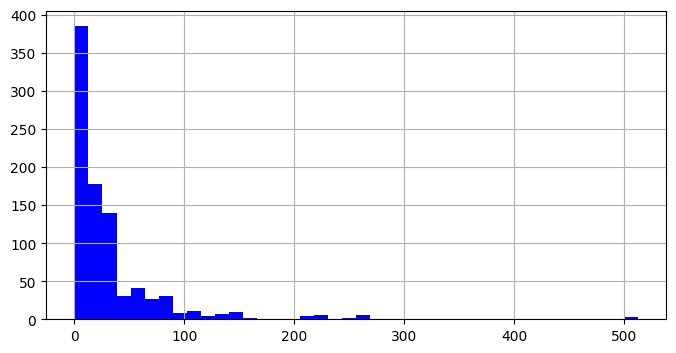

In [15]:
train['Fare'].hist(color='blue',bins=40,figsize=(8,4))

###### It can be obeserved that the Fare has some positive correlation with the survival of the passanger.
The chances of survival of a passanger are improving as the fare is increasing.

# Bivariate Analysis

<Axes: xlabel='Pclass', ylabel='Age'>

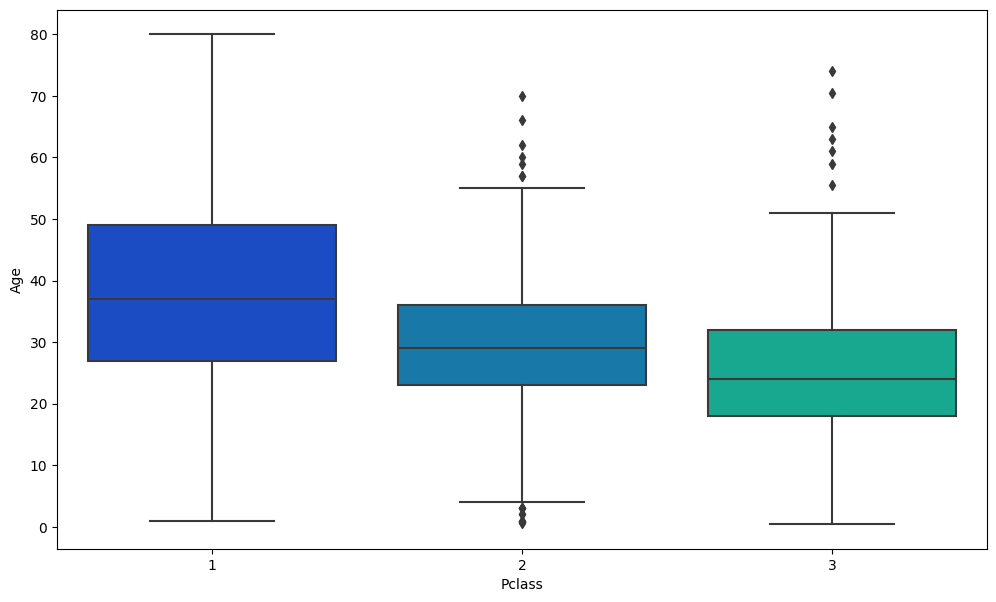

In [18]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [142]:
train.head()

,PassengerId,Survived,Pclass,Gender,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


###### Removing irrelevent variables for prediction

In [141]:
nonPredicter=['Name','Ticket']
train.drop(nonPredicter,axis=1,inplace=True)

### Encoding

In [143]:
sex = pd.get_dummies(train['Gender'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [144]:
train = pd.concat([train,sex,embark],axis=1)

In [145]:
train = train.drop(['Embarked','Gender'],axis = 1)

In [126]:
#train.set_index('PassengerId', inplace=True)

In [129]:
train.reset_index(inplace=True)

In [146]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [147]:
# Split the dataframe into data and labels
X_train = train.drop('Survived', axis=1) # data
y_train = train['Survived'] # labels

In [148]:
X_train.shape

(891, 9)

In [149]:
y_train.shape

(891,)

In [150]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return model, train_pred, acc, acc_cv

In [151]:
# Logistic Regression
start_time = time.time()
log_model, train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 78.56
Accuracy CV 10-Fold: 77.55
Running Time: 0:00:02.555990


In [152]:
# Decision Tree Classifier
start_time = time.time()
dt_model, train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 72.62
Running Time: 0:00:00.193868


In [153]:
# Gradient Boosting Trees
start_time = time.time()
gbt_model, train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.34
Accuracy CV 10-Fold: 76.99
Running Time: 0:00:01.801706


In [154]:
X_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


In [155]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [156]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Decision Tree', 'Gradient Boosting Trees'],
    'Score': [ acc_log,acc_dt,acc_gbt,]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
1,Decision Tree,100.00
2,Gradient Boosting Trees,89.34
0,Logistic Regression,78.56


In [157]:
cv_models = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_log,       
        acc_cv_dt,
        acc_cv_gbt,
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
0,Logistic Regression,77.55
2,Gradient Boosting Trees,76.99
1,Decision Tree,72.62


In [82]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    plt.savefig('catboost_feature_importance.png')

,imp,col
7,0.000000,Q
8,0.014237,S
4,0.020320,Parch
3,0.042283,SibSp
1,0.105050,Pclass
5,0.157399,Fare
2,0.163073,Age
0,0.206730,PassengerId
6,0.290907,male


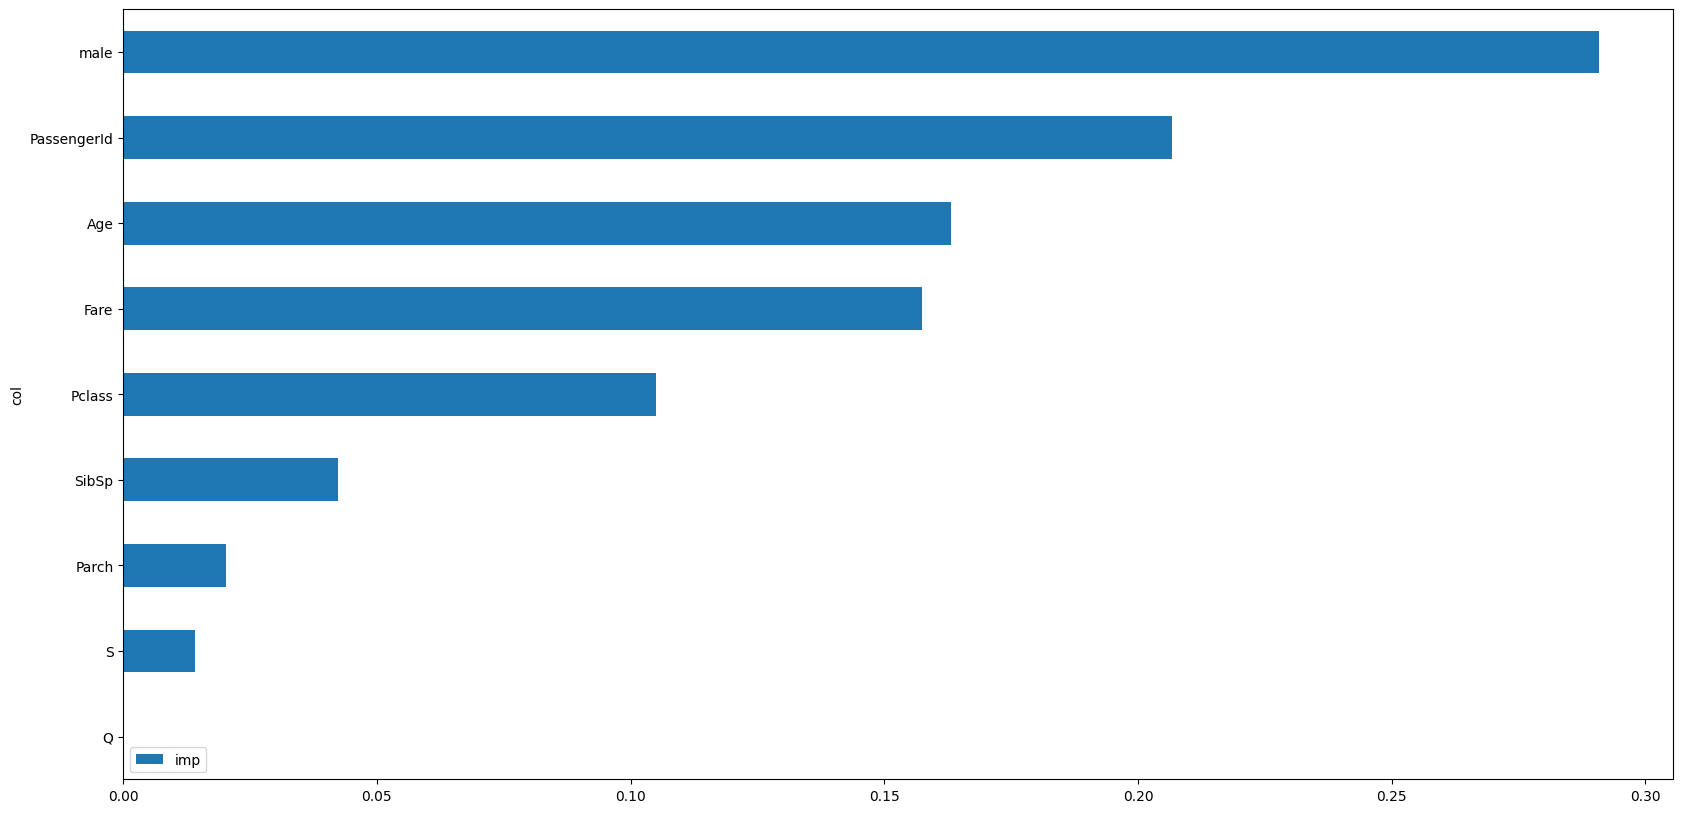

In [158]:
# Plot the feature importance scores
feature_importance(dt_model, X_train)

In [159]:
# We need our test dataframe to look like this one
X_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


## Testing:

In [160]:
test = pd.read_csv('tt_test.csv')

In [161]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [162]:
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

In [163]:
test.drop('Cabin', axis=1 , inplace = True)

In [164]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [165]:
sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)

In [166]:
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [167]:
test = pd.concat([test,sex,embark],axis=1)

In [168]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


In [169]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [170]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q',
       'S'],
      dtype='object')

In [171]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = dt_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [172]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [173]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions 
# our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,1


## Save Model file

In [179]:
with open('titanic_dt_model.pkl','wb') as model:
    pickle.dump(dt_model,model)

### Save Prediction CSV

In [186]:
# Let's convert our submission dataframe 'Survived' column to integers
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [174]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,1


In [175]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [176]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('dt_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!
